# Example 1: Using Jupyter, MIBI dataset

If you have a dataset can be processed on your own computer, using Jupyter environment for data analysis and visualization is pretty convenient.

## Data description

In this example I use MIBI dataset from this article:

[A Structured Tumor-Immune Microenvironment in Triple Negative Breast Cancer Revealed by Multiplexed Ion Beam Imaging](https://doi.org/10.1016/j.cell.2018.08.039)

**Download the data** for following analysis: [Link](https://uofmacau-my.sharepoint.com/:u:/g/personal/yb97643_umac_mo/ET7-chqWIc9EqSEtY-foQ7IBURusGw9hlTSBC3xD_bNdgw?download=1)

For origin data, follow their instruction in the article to request it. The processed data is placed at their [lab's page](https://www.angelolab.com/mibi-data). The data contains 41 patients, one ROI per patient.


The following example runs on an iMac 8-cores/40G RAM.

In [1]:
import numpy as np
import pandas as pd

First let's read the data, I have already processed their data into anndata object.

Because some of the background region are also marked as a cell in their mask images, we can filter out most of it based on area size.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import anndata as ad
data = ad.read_h5ad("../data/mibi_TNBC_data.h5ad")
data = data[data.obs['area'] < 1000].copy()
data

AnnData object with n_obs × n_vars = 174486 × 39
    obs: 'Patient', 'area', 'cell_shape', 'centroid', 'eccentricity', 'cell_type', 'Stage'
    var: 'markers'

In [4]:
import spatialtis as st
import spatialtis.plotting as sp
from spatialtis import CONFIG

CONFIG.EXP_OBS = ['Patient', 'Stage']
CONFIG.CELL_TYPE_KEY = "cell_type"
CONFIG.MARKER_KEY = "markers"

CONFIG

Declare some variables to use afterwards

In [5]:
immune_cells = ['Macrophages', 'Tregs', 'CD4 T', 'CD3 T', 'CD8 T', 'NK', 'B', 'Neutrophils', 'DC', 'DC/Mono']
group_order = {'Stage': [f'Stage {i}' for i in range(1, 5)]}

# exclude nuclear markers and cell skeleton markers
selected_markers = ['FoxP3', 'Lag3', 'CD4', 'CD16', 'CD56', 'OX40', 'PD1', 
                    'CD31', 'PD-L1', 'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 'CD163', 'CD68', 
                    'CSF-1R', 'CD8', 'CD3', 'IDO', 'Keratin17', 'CD63', 'CD45RO', 'CD20', 'p53',
                    'HLA-DR', 'CD11b', 'CD45', 'Pan-Keratin', 'MPO', 'Keratin6', 'HLA_Class_1']

## Basic Statistic of spatial single cell data

- Cell components
- Cell density
- Cell morphology (eg. area, eccentricity...)
- Cell co-occurrence

In [17]:
from collections import Counter
Counter([n[0] for n, g in data.obs.groupby(['Stage', 'Patient'])])

Counter({'Stage 1': 6, 'Stage 2': 23, 'Stage 3': 7, 'Stage 4': 2})

### Cell components

This is to count the fraction of each cell type in different group

In [6]:
st.cell_components(data)

In [13]:
sp.cell_components(data, ['Stage'], 
                   size=(500, 400),
                   use="interactive",
                   selected_types=immune_cells,
                   group_order=group_order,
                   title="Immune Cells in TNBC",
                   xaxis_title="Cancer Stage", 
                   yaxis_title="Percentage of cells(%)",
                  )

### Cell density

This is to measure the density of cell in each ROI

In [14]:
st.cell_density(data, ratio=0.001)

The Keratin-positive tumor is obviously much denser than other cell

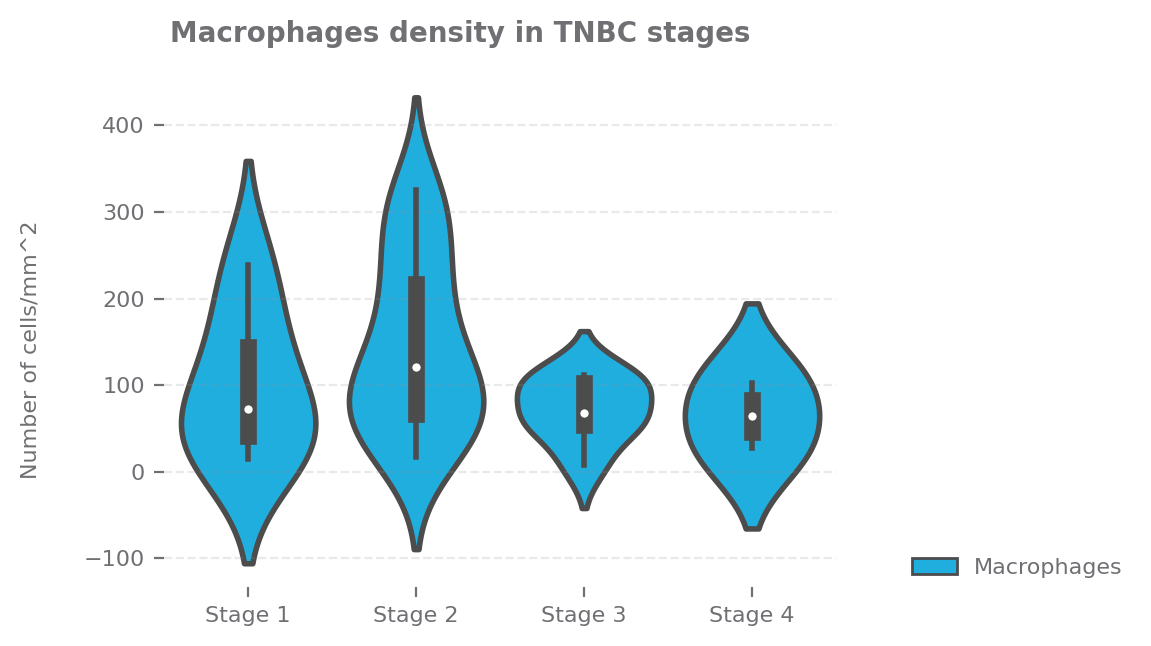

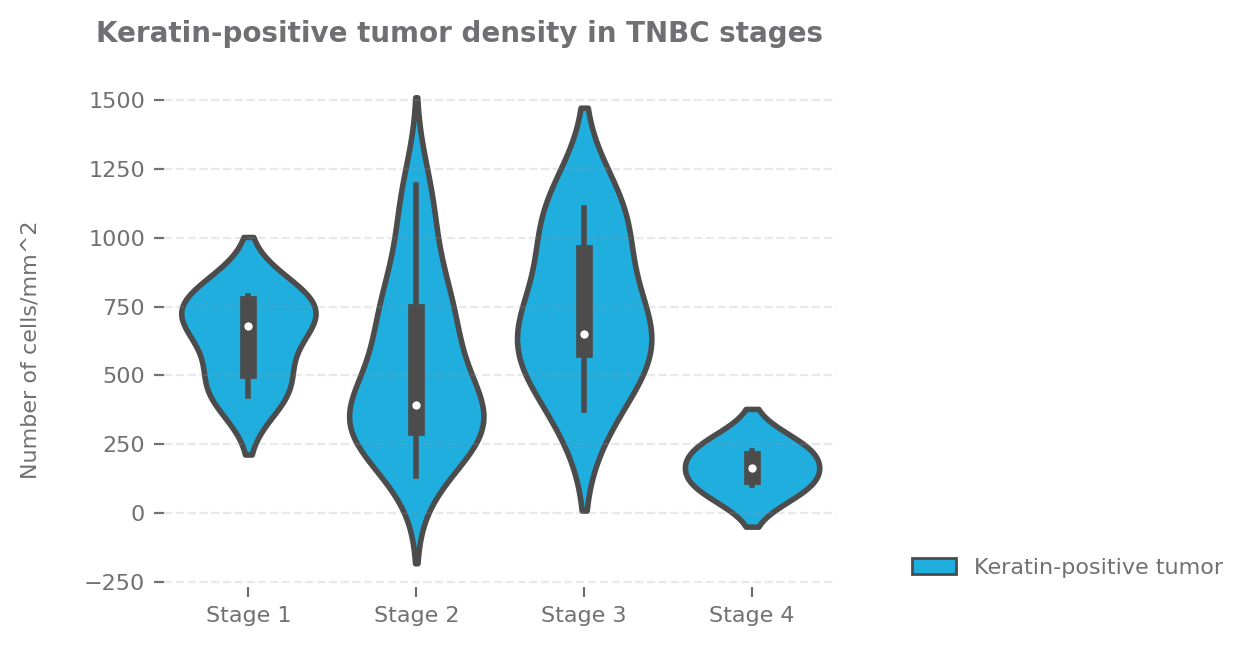

In [9]:
sp.cell_density(data,
                ['Stage'],
                selected_types=['Macrophages'],
                group_order=group_order,
                size=(4, 3),
                title="Macrophages density in TNBC stages",
                yaxis_title="Number of cells/mm^2",
               )
sp.cell_density(data,
                ['Stage'],
                selected_types=['Keratin-positive tumor'],
                group_order=group_order,
                size=(4, 3),
                title="Keratin-positive tumor density in TNBC stages",
                yaxis_title="Number of cells/mm^2",
               )

### Cell morphology

This is to measure the area or the eccentricity of cells, the default is to use eccentricity. The value of eccentricity get more close to 1 means the shape of the cell is more close to a circle.

In [31]:
st.cell_morphology(data)

In [35]:
st.get_result(data, 'morphology')['value'].mean()

0.6921018838404522

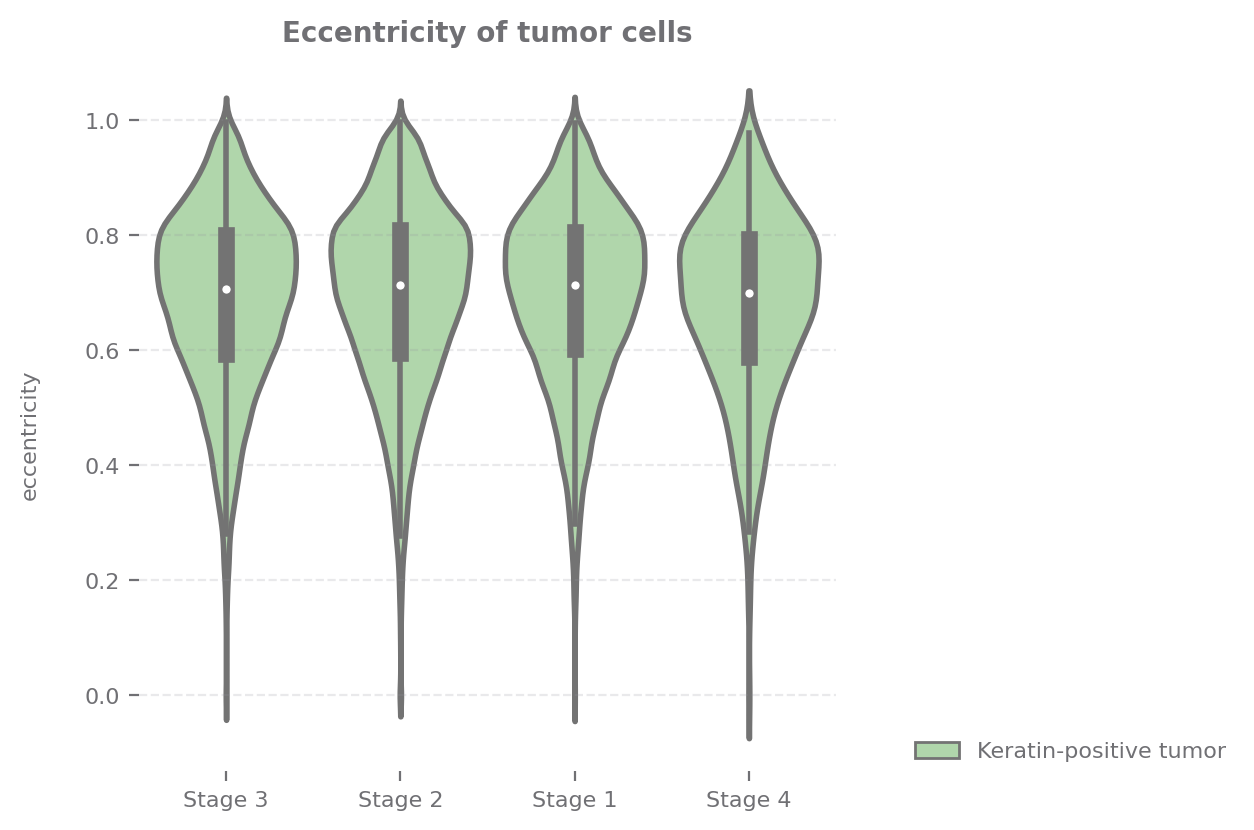

In [33]:
immune_cells = ['Keratin-positive tumor']
sp.cell_morphology(data,
                   ['Stage'],
                   selected_types=immune_cells, 
                   size=(4, 4), 
                   title="Eccentricity of tumor cells", 
                   yaxis_title="eccentricity",
                   palette=['#abdda4']
                  )

### Cell co-occurrence

This is to measure the likelihood of two type of cells occur in the same ROI

In [81]:
st.cell_co_occurrence(data)

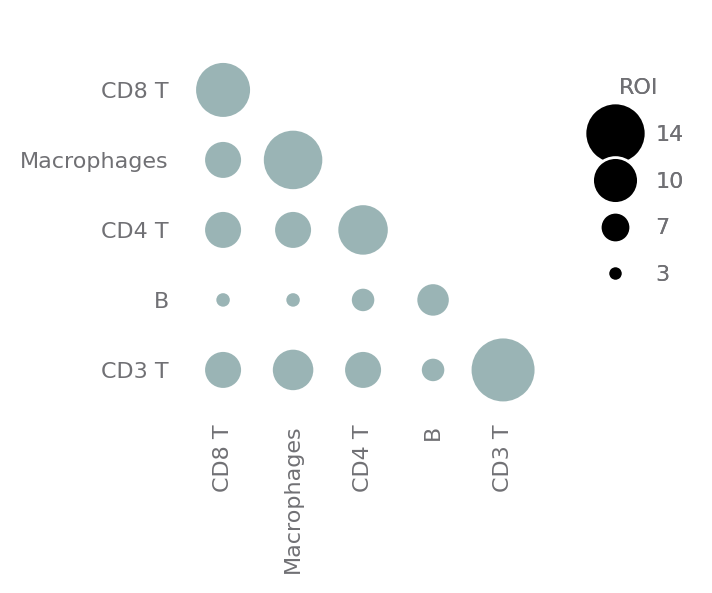

(pid=raylet) F0302 15:23:13.435098  1537 189021696 gcs_rpc_client.h:262] Couldn't reconnect to GCS server. The last attempted GCS server address was 10.8.229.194:50874
(pid=raylet) *** Check failure stack trace: ***
(pid=raylet)     @        0x1079e3152  google::LogMessage::~LogMessage()
(pid=raylet)     @        0x10799bb75  ray::RayLog::~RayLog()
(pid=raylet)     @        0x1076ae476  ray::rpc::GcsRpcClient::Reconnect()
(pid=raylet)     @        0x1076bfba6  _ZZN3ray3rpc12GcsRpcClient15ReportHeartbeatERKNS0_22ReportHeartbeatRequestERKNSt3__18functionIFvRKNS_6StatusERKNS0_20ReportHeartbeatReplyEEEEENKUlS9_SC_E_clES9_SC_
(pid=raylet)     @        0x1076bf53b  ray::rpc::ClientCallImpl<>::OnReplyReceived()
(pid=raylet)     @        0x1076fd9f5  _ZN5boost4asio19asio_handler_invokeIZN3ray3rpc17ClientCallManager29PollEventsFromCompletionQueueEiEUlvE_EEvRT_z
(pid=raylet)     @        0x1076fd9a4  _ZN5boost4asio6detail18completion_handlerIZN3ray3rpc17ClientCallManager29PollEventsFromCompletio

In [92]:
cells = ['Macrophages', 'CD3 T', 'CD4 T', 'CD8 T', 'B']
sp.cell_co_occurrence(data, selected_types=cells)

## Spatial analysis

- Spatial distribution
- Spatial heterogeneity
- Cell-cell interaction (Neighborhood analysis)
- Markers co-expression (Spatial enrichment analysis)
- Hotspot detection
- Spatial community detection
- Neighbor dependent markers

### Spatial distribution

The pattern of spatial distribution is `Random`, `Cluster`, `Regular`.

In [5]:
st.spatial_distribution(data)

Finding distribution pattern ██████████ 100% 00:00|00:00


In [27]:
st.spatial_distribution(data, export_key="nns")
st.spatial_distribution(data, r=50, method="vmr", export_key="vmr")
st.spatial_distribution(data, method="quad", export_key="quad")

Finding distribution pattern ██████████ 100% 00:00|00:00


Finding distribution pattern ██████████ 100% 00:00|00:00


Finding distribution pattern ██████████ 100% 00:00|00:00


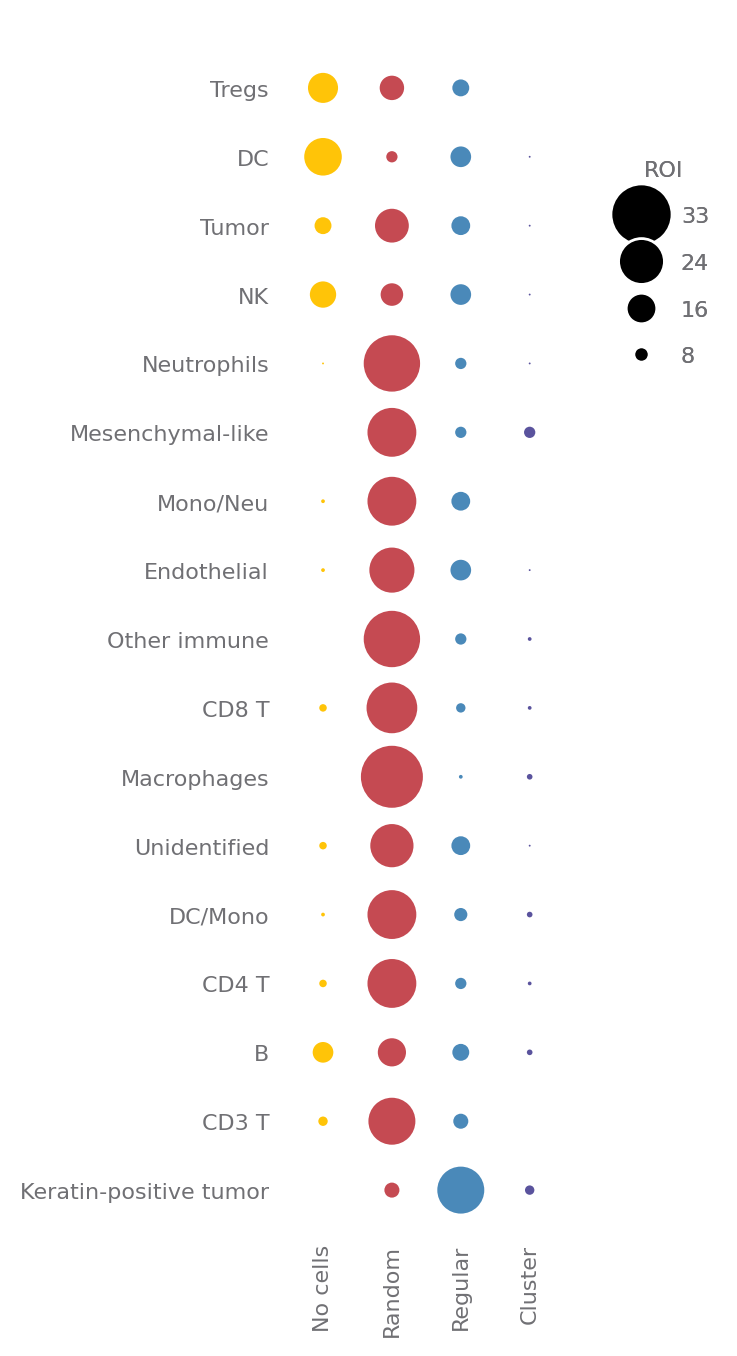

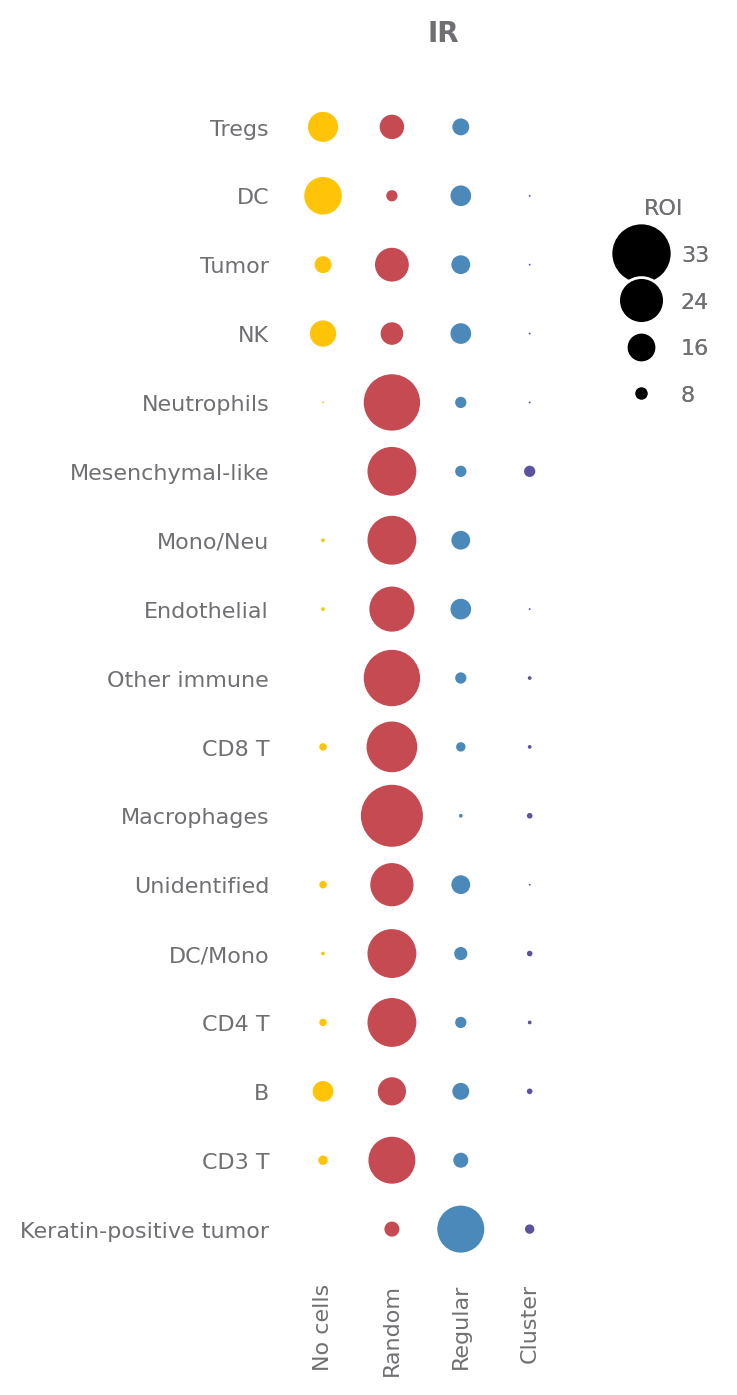

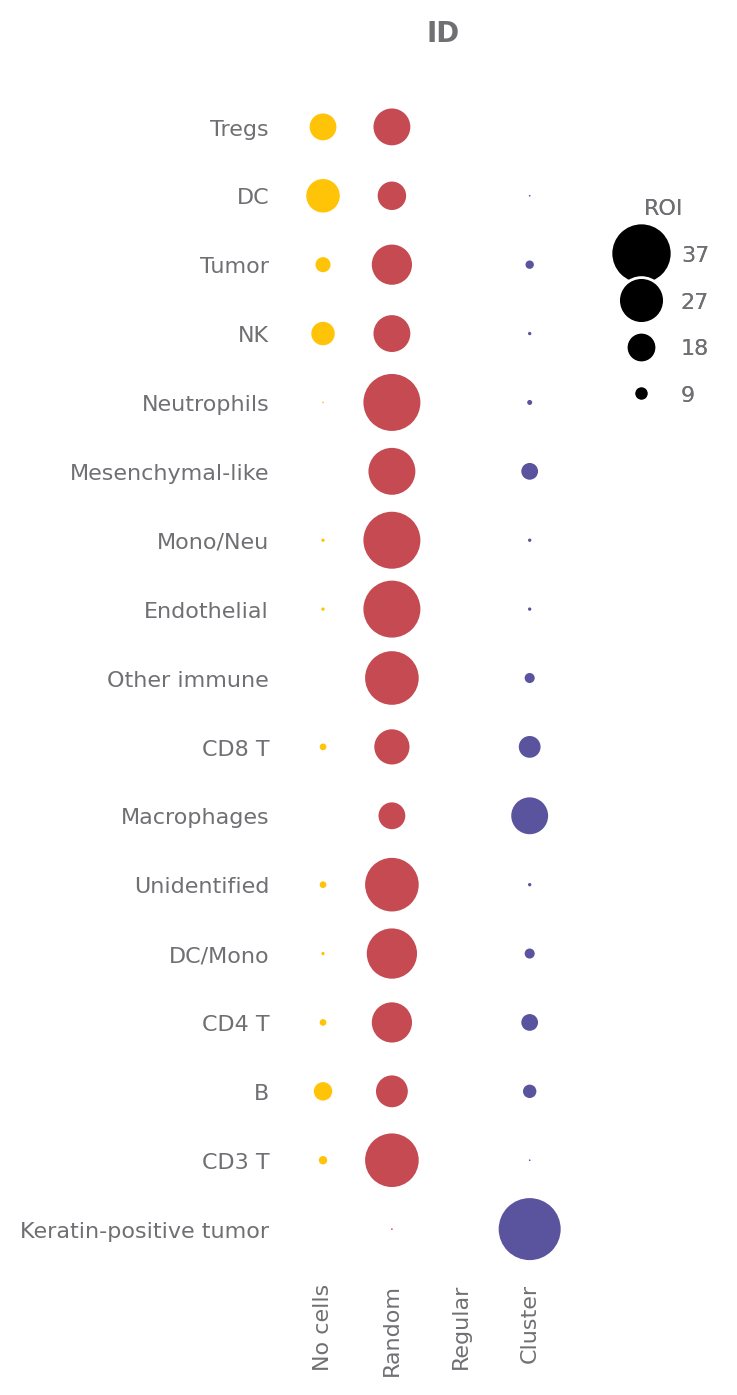

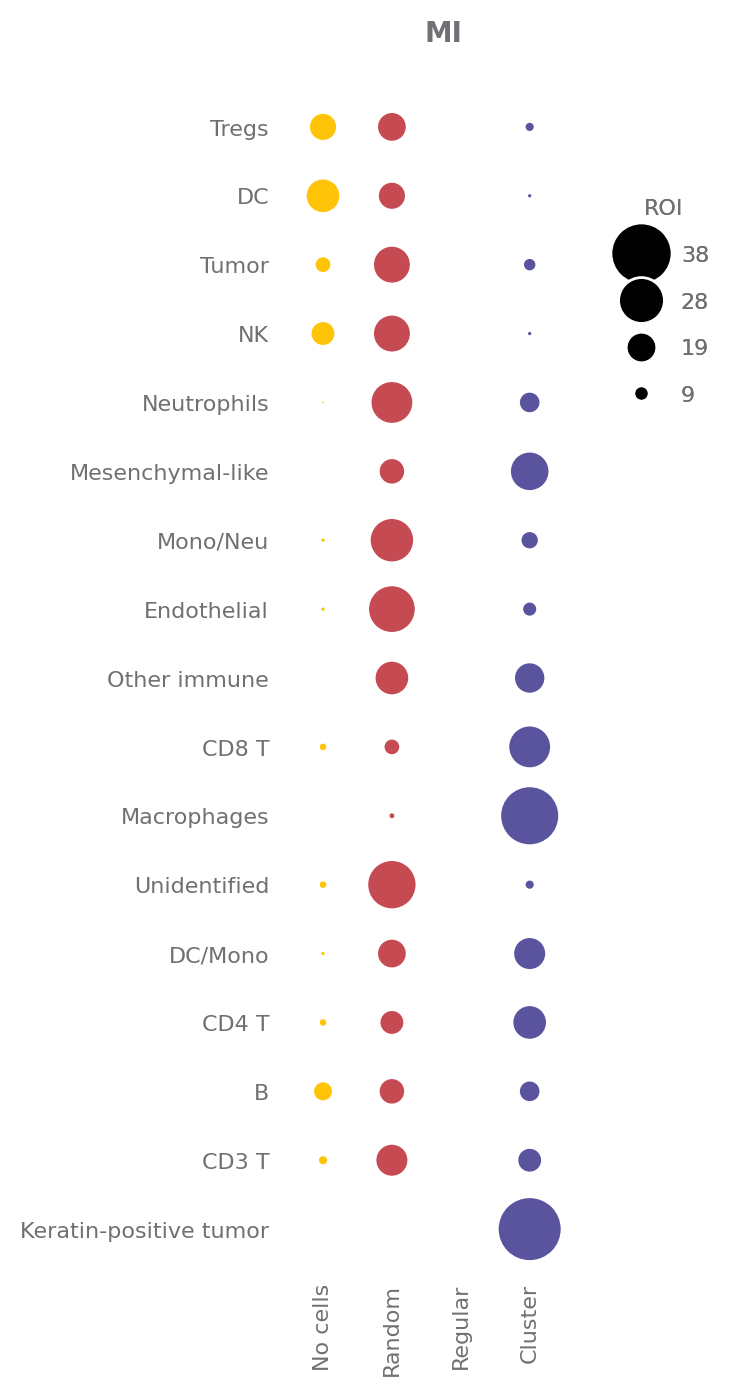

In [30]:
sp.spatial_distribution(data, key="nns")
sp.spatial_distribution(data, key="nns", title="IR")
sp.spatial_distribution(data, key="vmr", title="ID")
sp.spatial_distribution(data, key="quad", title="MI")

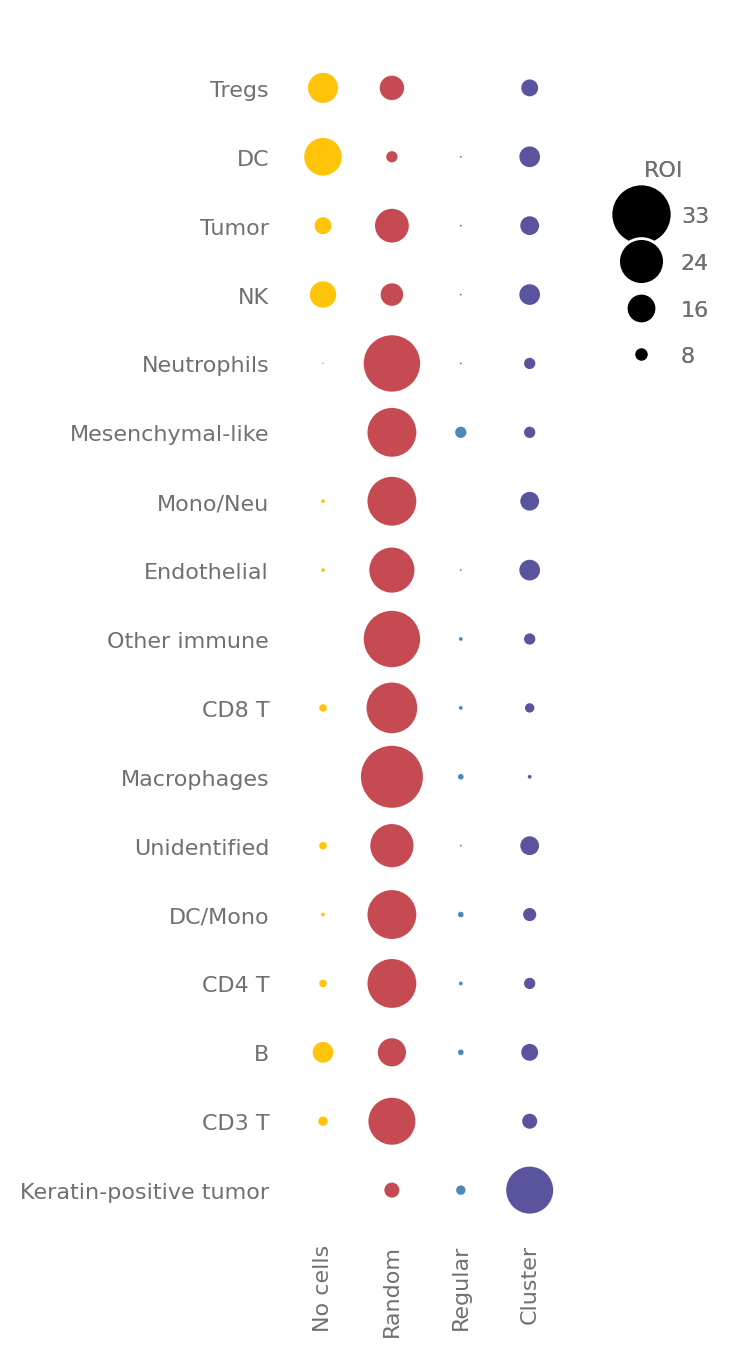

In [6]:
sp.spatial_distribution(data, use="dot")

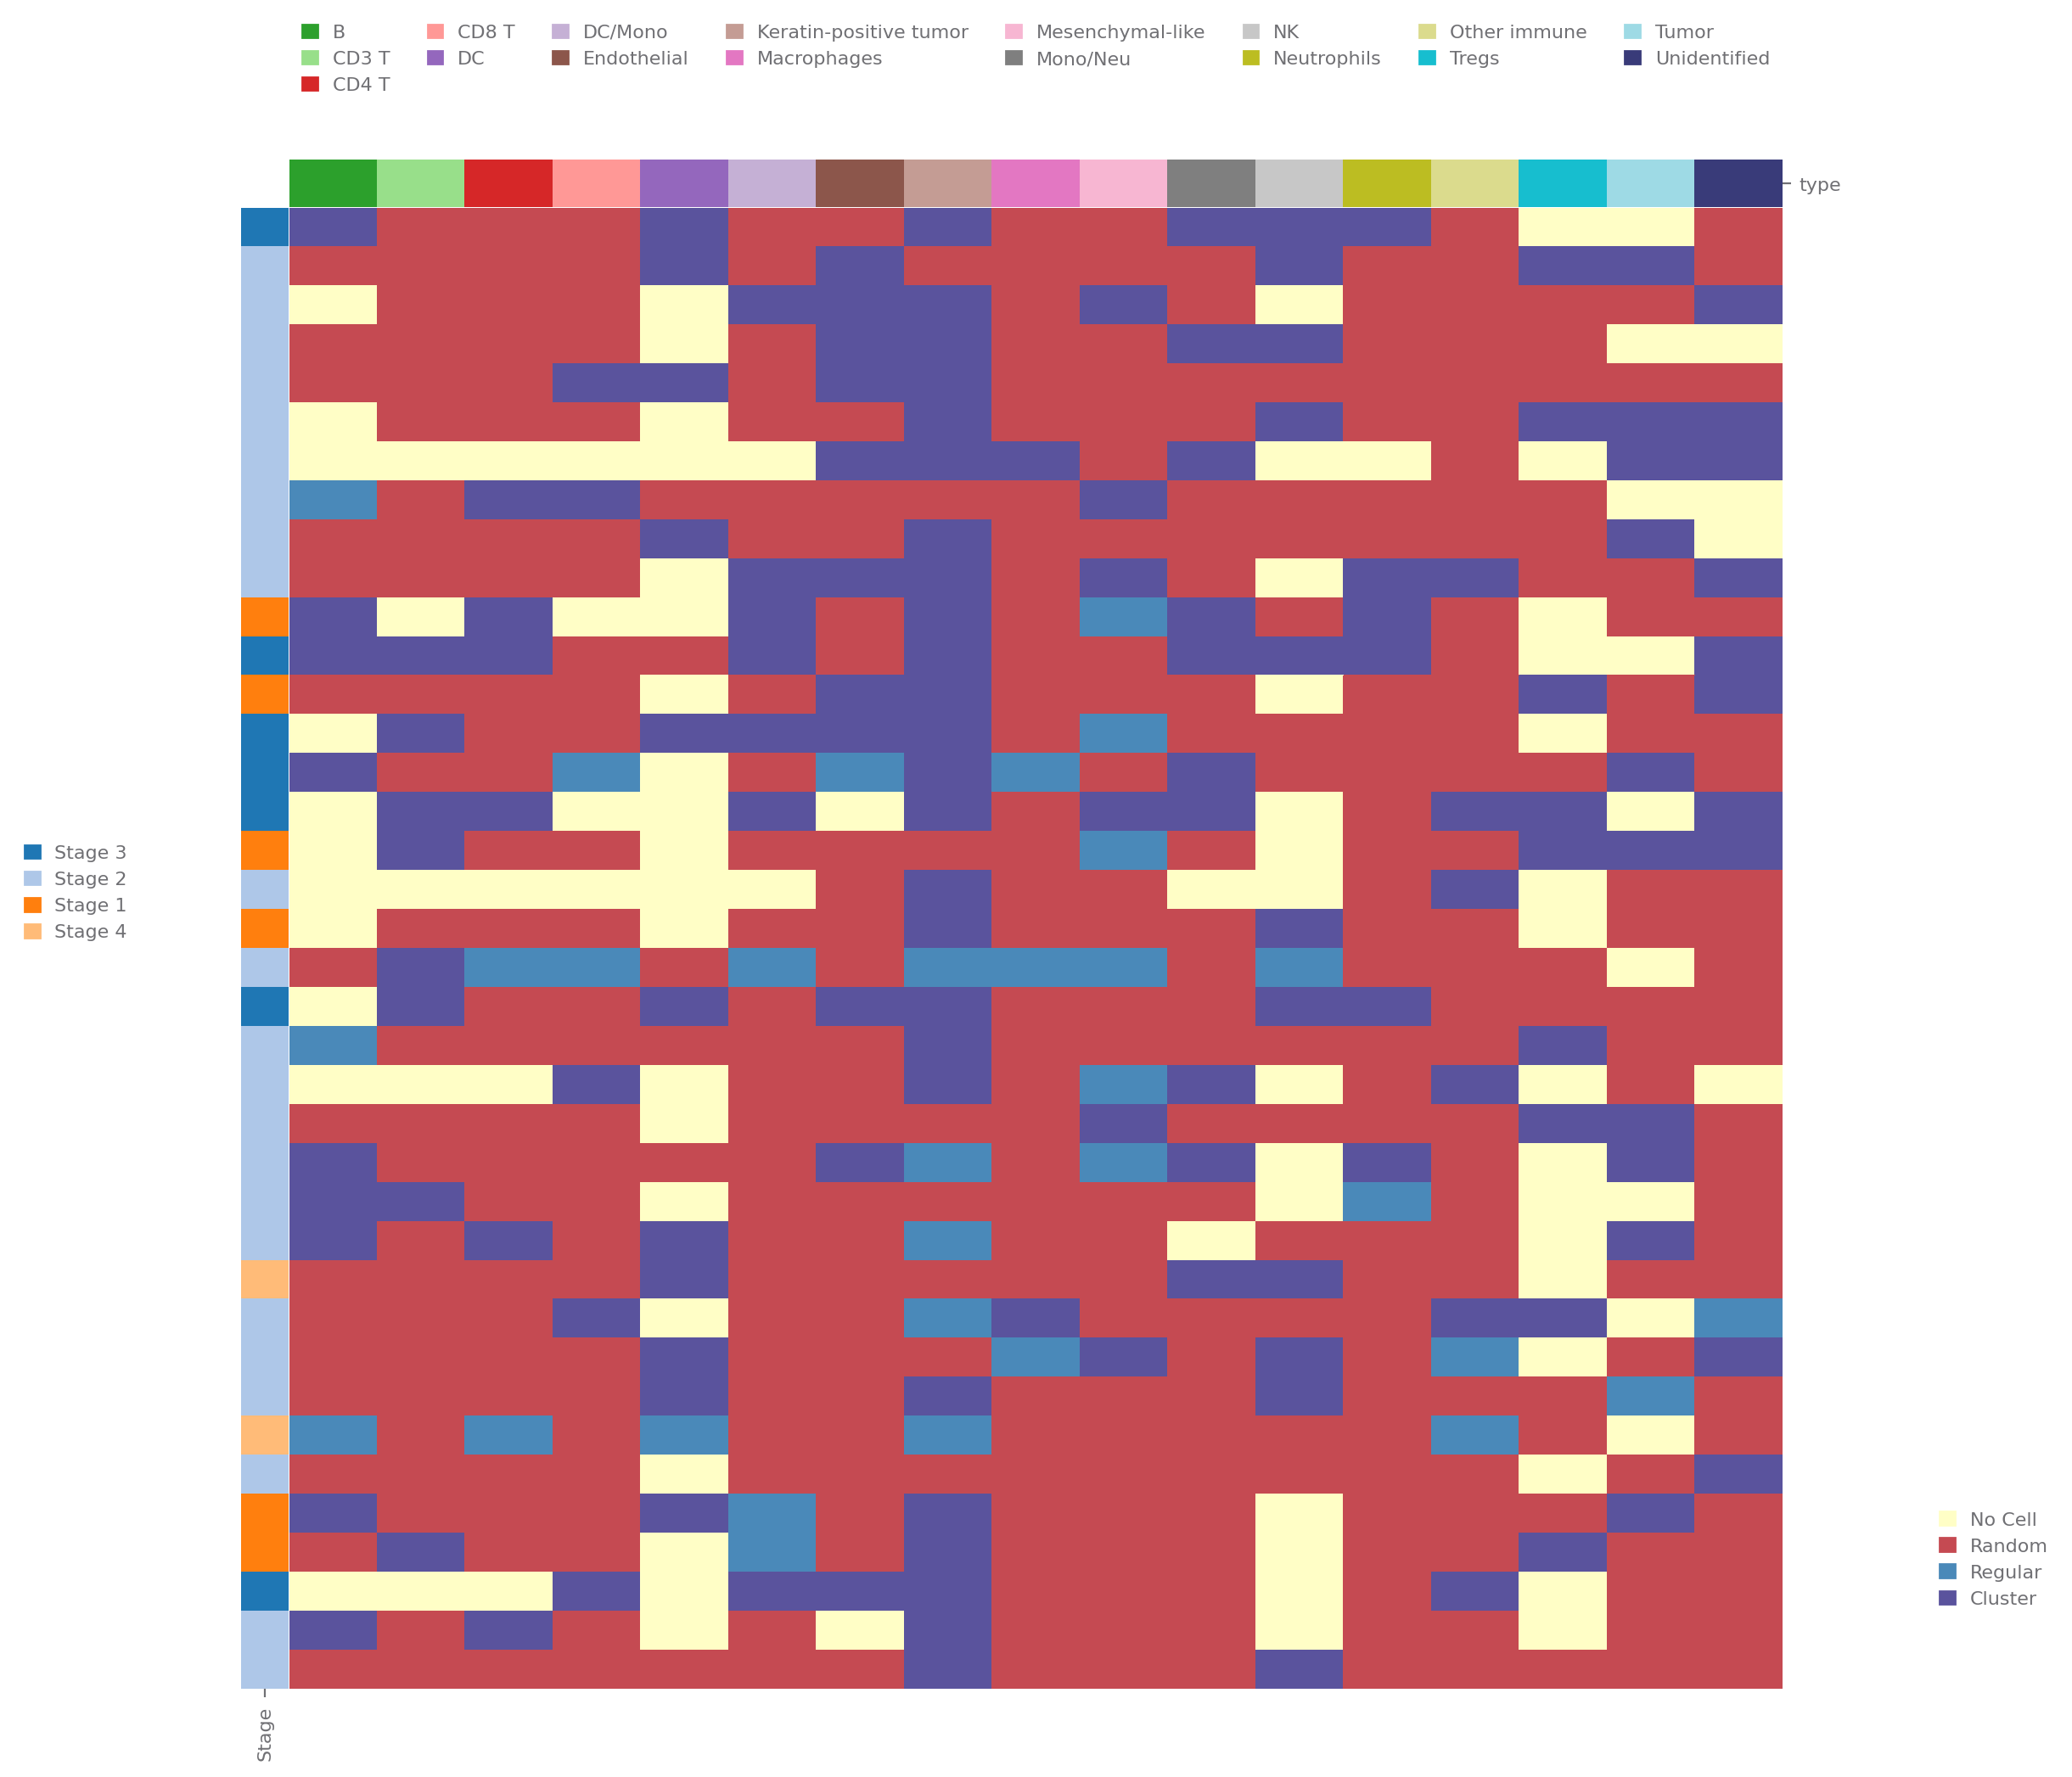

In [11]:
sp.spatial_distribution(data, ['Stage'], use="heatmap", 
                        clustermap_kwargs=dict(col_cluster=False, row_cluster=False))

### Spatial Heterogeneity

SpatialTis implemented 3 entropy based methods to quantify the heterogeneity

- Shannon entropy
- Altieri entropy
- Leibovici entropy

Check [spatialentropy](https://github.com/Mr-Milk/SpatialEntropy) if you are interested.

In [14]:
st.spatial_heterogeneity(data,).result# method="altieri", cut=10)

Calculating heterogeneity ██████████ 100% 00:00|00:05


,Patient,Stage,heterogeneity
0,Patient 1,Stage 3,1.727062
1,Patient 2,Stage 3,1.424620
2,Patient 3,Stage 2,2.188746
3,Patient 4,Stage 2,2.480519
4,Patient 5,Stage 1,2.063514
5,Patient 6,Stage 1,1.755746
6,Patient 7,Stage 3,1.032032
7,Patient 8,Stage 2,1.720015
8,Patient 9,Stage 2,2.049918
9,Patient 10,Stage 2,2.023856


In [15]:
st.spatial_heterogeneity(data, method="shannon", export_key="shannon").result

,Patient,Stage,heterogeneity
0,Patient 1,Stage 3,1.654558
1,Patient 2,Stage 3,1.377953
2,Patient 3,Stage 2,2.093683
3,Patient 4,Stage 2,2.345168
4,Patient 5,Stage 1,1.968528
5,Patient 6,Stage 1,1.636107
6,Patient 7,Stage 3,0.992828
7,Patient 8,Stage 2,1.644631
8,Patient 9,Stage 2,1.921527
9,Patient 10,Stage 2,1.926221


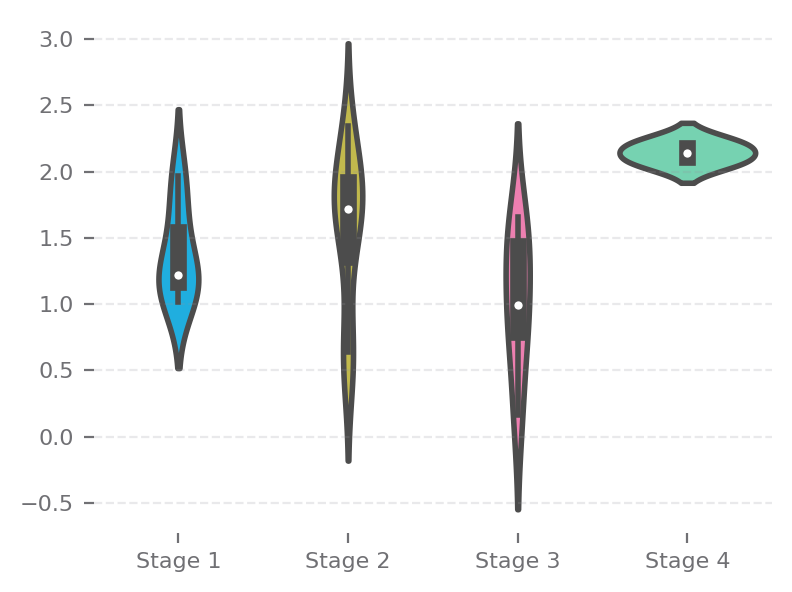

In [13]:
sp.spatial_heterogeneity(data, ['Stage'], key="shannon", group_order=group_order, size=(4, 3))

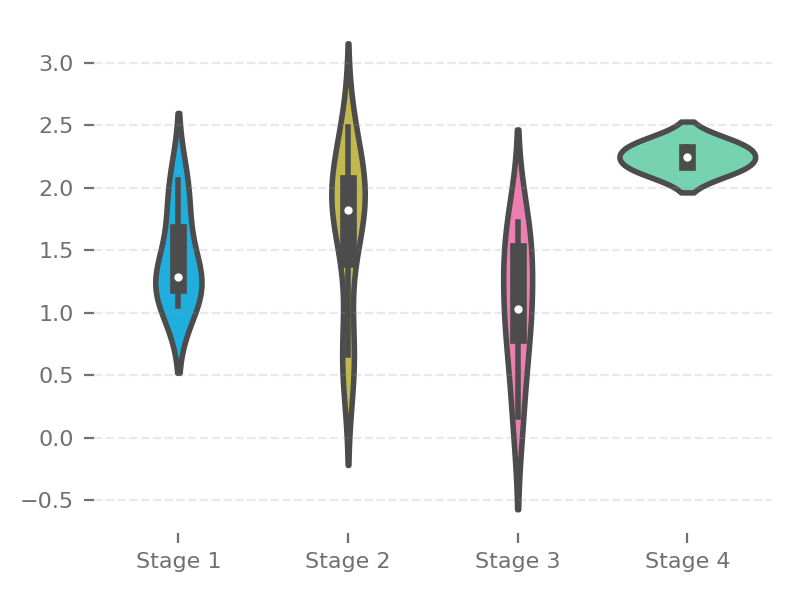

In [16]:
sp.spatial_heterogeneity(data, ['Stage'], group_order=group_order, size=(4, 3))

### Finding cell neighbors

Intiate a `Neighbors` instance to find neighbors for each cells.

This MIBI dataset has cell shape data, we can search using default setting. For data resolved cell as point, pass `geom="point"`

SpatialTis search the neighbors of a cell by enlarge the cell

`scale=1.5` will scale the cell at 1.5 fold (shape data)

`expand=5` will expand the cell by 5 unit (shape data, point data)

In [7]:
st.find_neighbors(data, use_shape=True, expand=5)

Get cell bbox ██████████ 100% 00:00|00:08
Find neighbors              0% 00:00|00:00


You can also visualize the cell neighbors in any ROI

### Neighborhood analysis

To profile the cell-cell relationship, neighborhood analysis tells you whether two type of cells are **association** or **avoidance**. 

Association means they are likely to occur at one's neighborhood

Avoidance means they tend to avoid to see one another

Neither means the relationship is random

Check [neighborhood_analysis](https://github.com/Mr-Milk/neighborhood_analysis) if you are interested.

<div class="alert alert-block alert-info">
Notice something is different in the parameter of the following analysis function, we pass in (n) a spatialtis.Neighbor instance instead of (data) a anndata object.
</div>

In [55]:
st.neighborhood_analysis(data)

Neighborhood analysis ██████████ 100% 00:00|00:05


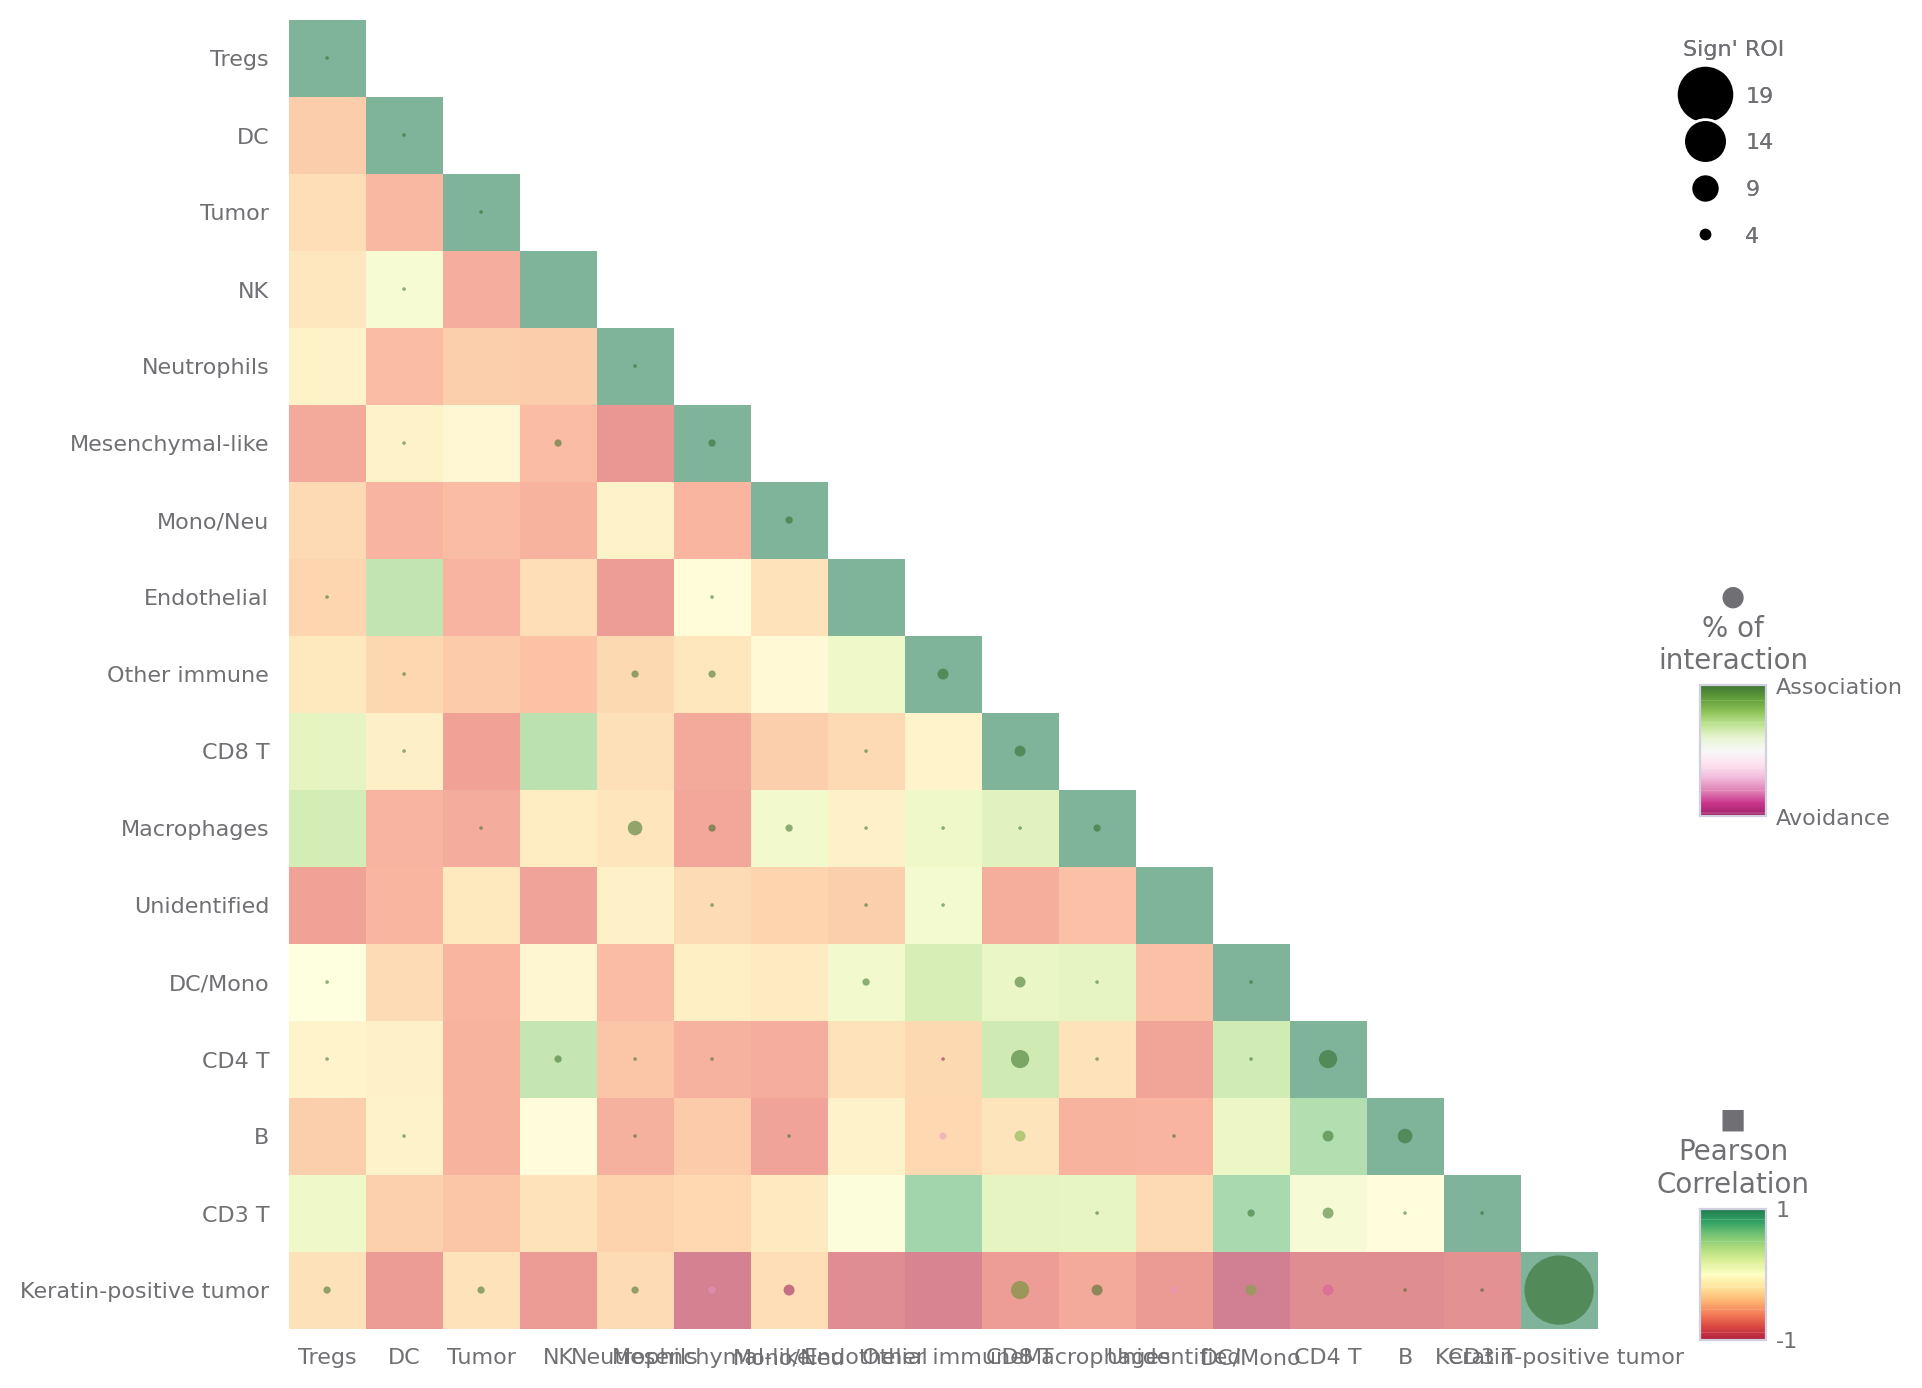

In [60]:
sp.neighborhood_analysis(data)

### Spatial enrichment analysis

Profiling markers co-expression

In [27]:
st.spatial_enrichment_analysis(data, selected_markers=selected_markers)

Spatial enrichment analysis ██████████ 100% 00:00|01:46


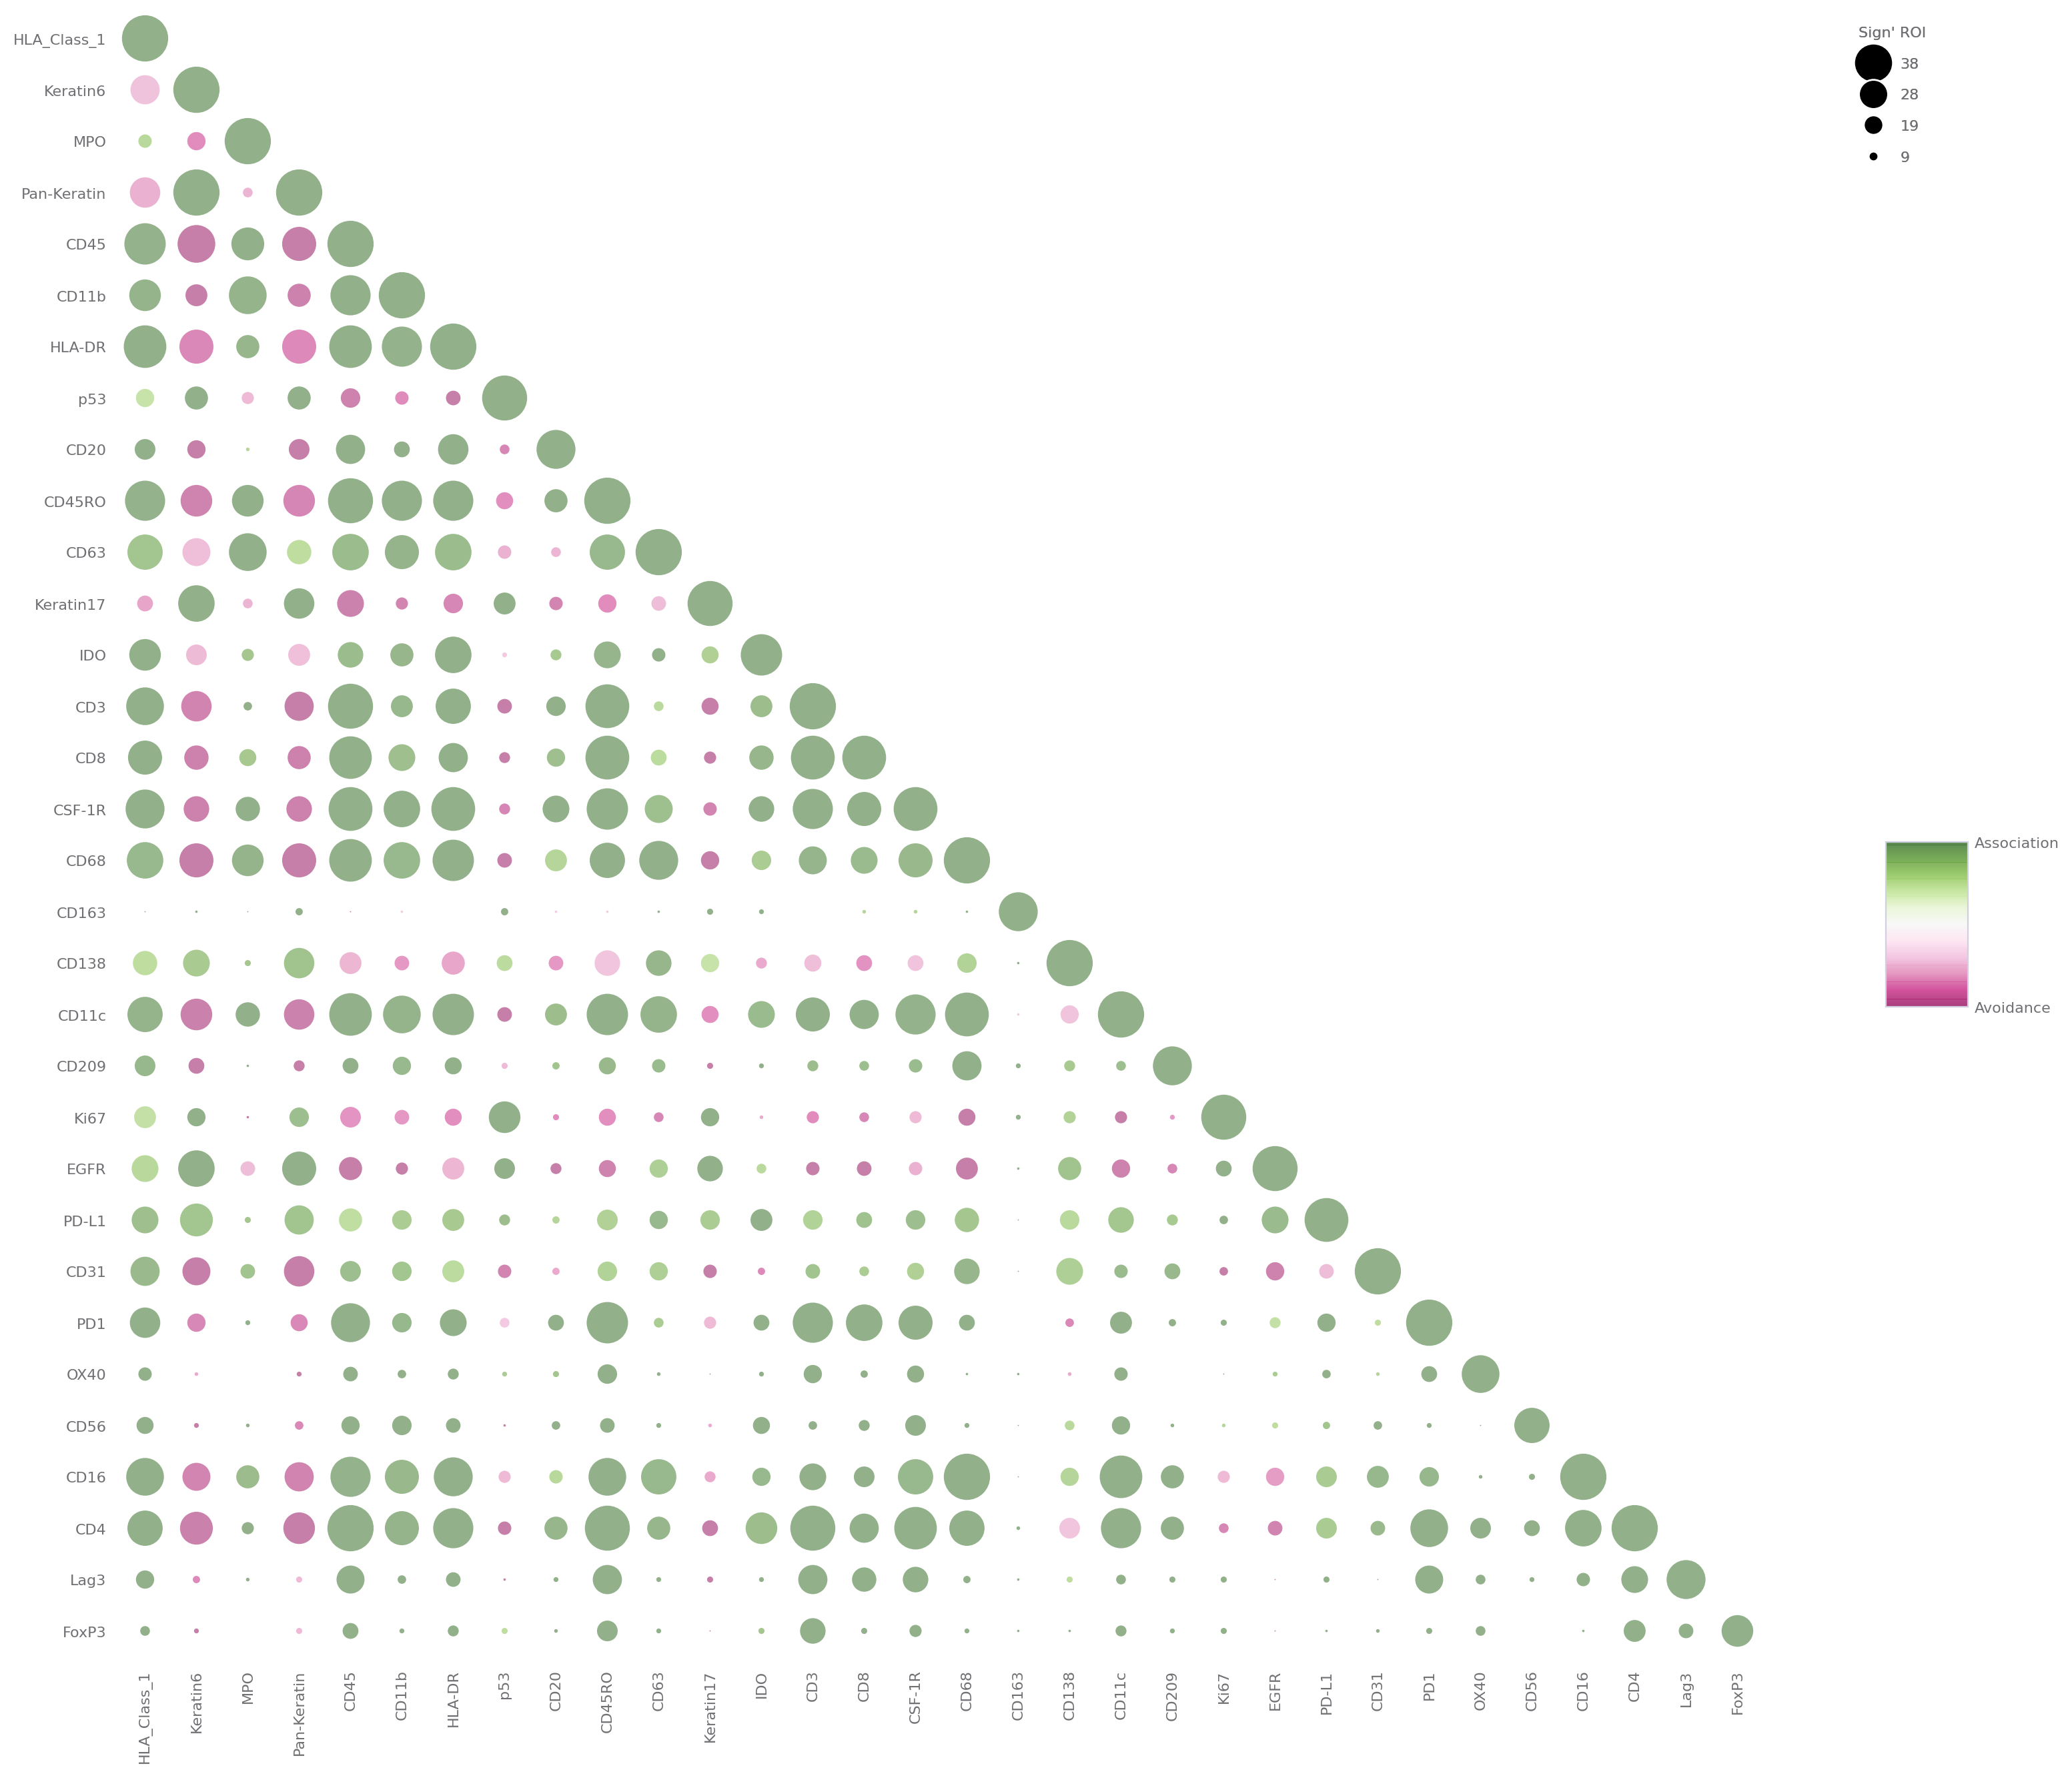

In [28]:
sp.spatial_enrichment_analysis(data)

### Spatial co-expression

In [71]:
st.spatial_co_expression(data)

co-expression ██████████ 100% 00:00|00:04


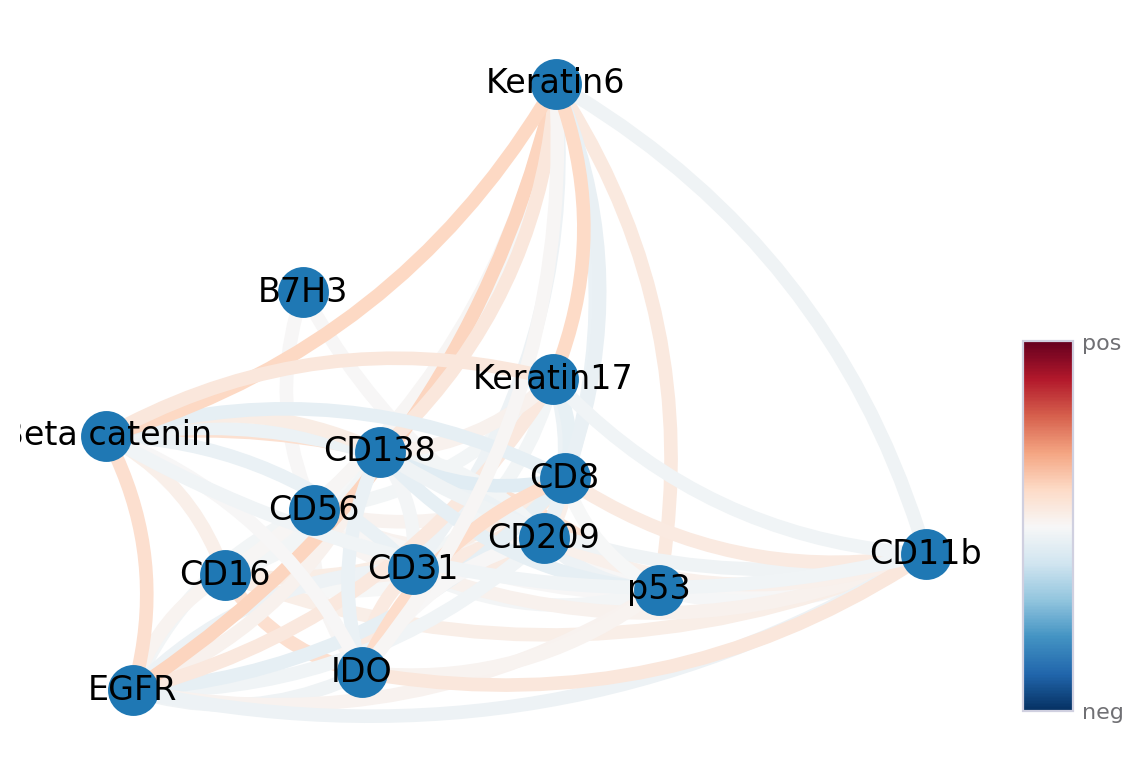

In [72]:
sp.spatial_co_expression(data)

Always remember to save your results by writing to the anndata file, otherwise it only store in the RAM

In [13]:
st.NCDMarkers(data, corr_cutoff=0, exp_std_cutoff=0)

NCD Markers ██████████ 100% 00:00|00:09


In [10]:
df = st.get_result(data, 'ncd_markers')

In [33]:
#data.write(data)